In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['seg_train', 'seg_pred', 'seg_test']


# Prepare Data

In [2]:
# import pytorch modules
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from torchvision.datasets import ImageFolder

# path
train_path = '../input/seg_train/seg_train'
test_path = '../input/seg_test/seg_test'
valid_path = '../input/seg_pred/seg_pred'


transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])



train_data = datasets.ImageFolder(train_path, transform=transforms)
test_data = datasets.ImageFolder(test_path, transform=transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=300, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=300)

len(trainloader)

47

Create a list of Classes

In [3]:
classes = ["buildings", "forest", "glacier", "mountain", "sea", "street"]

Visualize data

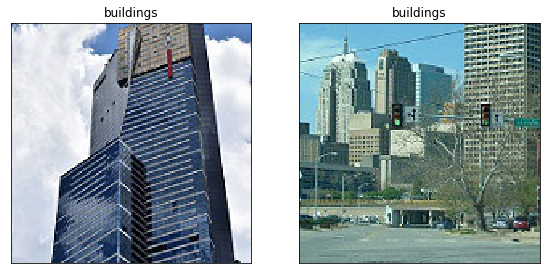

In [4]:
import numpy as np
import matplotlib.pyplot as plt

data_iter = iter(testloader)
images, labels = data_iter.next()

fig = plt.figure(figsize=(25, 5))
for idx in range(2):
    ax = fig.add_subplot(1, 5, idx + 1, xticks=[], yticks=[])
    # unnormolaize first
    img = images[idx] / 2 + 0.5
    npimg = img.numpy()
    img = np.transpose(npimg, (1, 2, 0)) #transpose
    ax.imshow(img, cmap='gray')
    ax.set_title(classes[labels[idx]])

Load Pretrined Model

In [5]:
model = models.resnet50(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:02<00:00, 38381479.38it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

Freeze the parameters

In [6]:
for pram in model.parameters():
    pram.requires_grad = False

Replace Classifier

In [7]:
import torch.nn as nn

model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
                nn.Dropout(p=0.5),
               nn.Linear(128, 6),
    nn.Softmax(dim=1)
)


Loss funcation and optimizer

In [8]:
import torch.optim as optim
import torch

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
#gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

Train model

In [9]:
# from tqdm import tqdm
accuracies = []
epochs = 5
steps = 0
running_loss = 0
print_every = 10
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
#         print(labels[0],logps[0])
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            accuracies.append(accuracy)
            running_loss = 0
            model.train()

Epoch 1/5.. Train loss: -0.420.. Test loss: -0.749.. Test accuracy: 0.807
Epoch 1/5.. Train loss: -0.720.. Test loss: -0.837.. Test accuracy: 0.871
Epoch 1/5.. Train loss: -0.813.. Test loss: -0.852.. Test accuracy: 0.871
Epoch 1/5.. Train loss: -0.828.. Test loss: -0.848.. Test accuracy: 0.860
Epoch 2/5.. Train loss: -0.836.. Test loss: -0.873.. Test accuracy: 0.883
Epoch 2/5.. Train loss: -0.850.. Test loss: -0.877.. Test accuracy: 0.887
Epoch 2/5.. Train loss: -0.858.. Test loss: -0.875.. Test accuracy: 0.888
Epoch 2/5.. Train loss: -0.859.. Test loss: -0.882.. Test accuracy: 0.890
Epoch 2/5.. Train loss: -0.857.. Test loss: -0.880.. Test accuracy: 0.889
Epoch 3/5.. Train loss: -0.865.. Test loss: -0.878.. Test accuracy: 0.886
Epoch 3/5.. Train loss: -0.866.. Test loss: -0.875.. Test accuracy: 0.881
Epoch 3/5.. Train loss: -0.861.. Test loss: -0.880.. Test accuracy: 0.886
Epoch 3/5.. Train loss: -0.866.. Test loss: -0.889.. Test accuracy: 0.897
Epoch 3/5.. Train loss: -0.879.. Test 

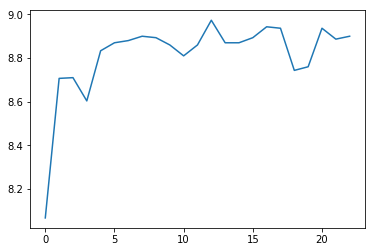

In [10]:
plt.plot(range(len(accuracies)),accuracies)

Calculate Accuracy

In [11]:
# track test loss
classes = ["buildings", "forest", "glacier", "mountain", "sea", "street"]

test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

with torch.no_grad():
  model.eval()
  # iterate over test data
  for data, target in testloader:
      # move tensors to GPU if CUDA is available
      data, target = data.to(device), target.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data)
      # calculate the batch loss
      loss = criterion(output, target)
      # update test loss 
      test_loss += loss.item()*data.size(0)
      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)    
      # compare predictions to true label
      correct = np.squeeze(pred.eq(target.data.view_as(pred)))
      # calculate test accuracy for each object class
      for i in range(38):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

# average test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: -0.894597

Test Accuracy of buildings: 97% (74/76)
Test Accuracy of forest: 97% (48/49)
Test Accuracy of glacier: 86% (56/65)
Test Accuracy of mountain: 88% (67/76)
Test Accuracy of   sea: 97% (74/76)
Test Accuracy of street: 86% (33/38)

Test Accuracy (Overall): 92% (352/380)


Test Network

In [12]:
import numpy as np # linear algebra
from matplotlib import pyplot as plt
from PIL import Image
from glob import glob
import os
from os import path

classes = trainloader.dataset.class_to_idx

file = glob(os.path.join(valid_path, '*.jpg'))

for i in file[:5]:
    with Image.open(i) as f:
        img = transformer(f).unsqueeze(0)
        with torch.no_grad():
            out = model(img.to(device)).cpu().numpy()
            for key, value in classes.items():
                if value == np.argmax(out):
                    print(key)
            plt.imshow(np.array(f))
            plt.show()

NameError: name 'transformer' is not defined